   car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \

<ipython-input-16-400d4ed69ef8>:17: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


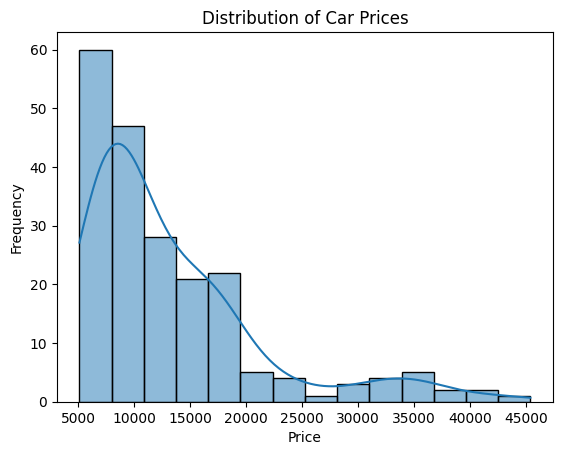

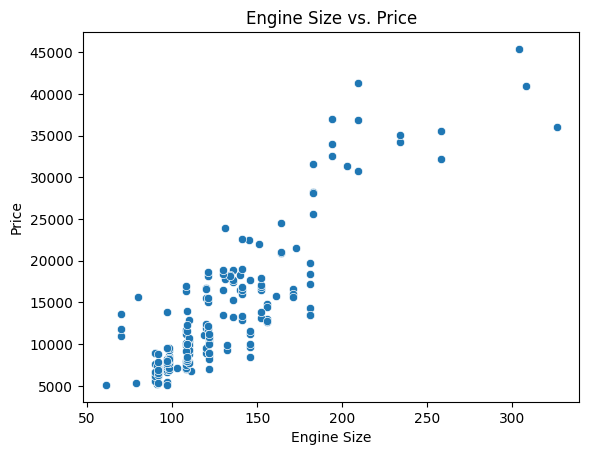

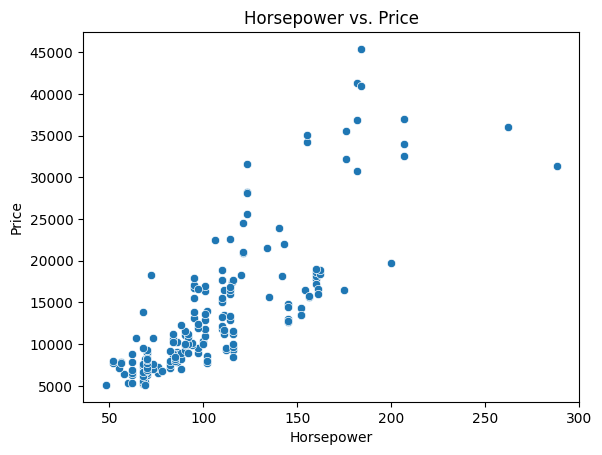

<ipython-input-16-400d4ed69ef8>:37: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


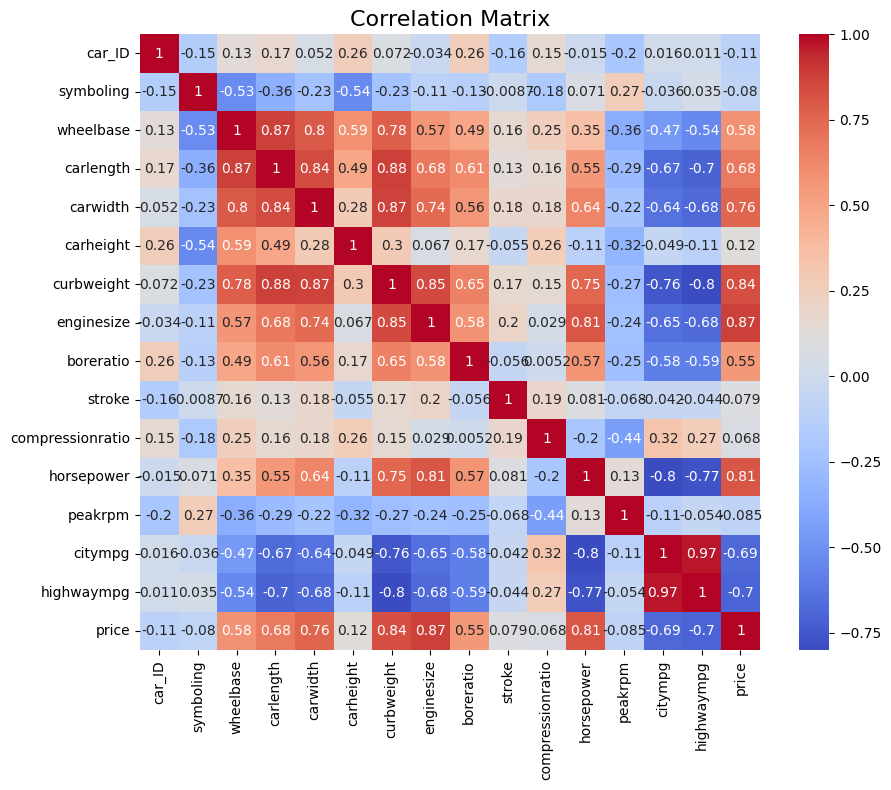

Shape of X_train: (164, 53)
Shape of X_test: (41, 53)
Shape of y_train: (164,)
Shape of y_test: (41,)
Shape of X_train_reduced: (164, 1)
Shape of X_test_reduced: (41, 1)
Shape of y_train: (164,)
Shape of y_test: (41,)


In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats

df = pd.read_csv("/content/CarPrice_Assignment.csv")

print(df.head())
print(df.info())

missing_values = df.isnull().sum()
print(missing_values)

df.fillna(df.mean(), inplace=True)

sns.histplot(df['price'], kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

sns.scatterplot(x='enginesize', y='price', data=df)
plt.title('Engine Size vs. Price')
plt.xlabel('Engine Size')
plt.ylabel('Price')
plt.show()

sns.scatterplot(x='horsepower', y='price', data=df)
plt.title('Horsepower vs. Price')
plt.xlabel('Horsepower')
plt.ylabel('Price')
plt.show()

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

df = pd.get_dummies(df, columns=['symboling', 'fueltype', 'aspiration', 'doornumber',
                                 'carbody', 'drivewheel', 'enginelocation', 'enginetype',
                                 'fuelsystem'])

scaler = MinMaxScaler()
numerical_features = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize',
                      'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
                      'highwaympg', 'price']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

df['enginesize'] = pd.to_numeric(df['enginesize'], errors='coerce')
df['cylindernumber'] = pd.to_numeric(df['cylindernumber'], errors='coerce')
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

non_numeric_columns = ['car_ID', 'CarName']
df.drop(non_numeric_columns, axis=1, inplace=True)
z_score = np.abs(stats.zscore(df))
df = df[(z_score < 3).all(axis=1)]

X_pca = X.drop(columns=['CarName'])
pca = PCA(n_components=0.95)

X_encoded = pd.get_dummies(X_pca)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_encoded)

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=11)

print(f"Shape of X_train_reduced: {X_train_reduced.shape}")
print(f"Shape of X_test_reduced: {X_test_reduced.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")